In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf 
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split 
import itertools
%matplotlib inline
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import make_scorer
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import sklearn.cluster as cluster
from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
palette = sns.color_palette('deep', 12)


# Feature Engineering

## Segment clustering

To combine the close segments together and create several models

In [205]:
df_clean = pd.read_csv('../01_Outputs/df_clean.csv')

In [206]:
df_clean['SPEC_length_x_width'] = df_clean['SPEC_overall_length_mm'] * df_clean['SPEC_overall_width_mm']
df_clean['SPEC_MYMakeModel'] = df_clean['PROFILE_Model_year'].astype(str) + '_' + df_clean['PROFILE_Make'] + '_' + df_clean['PROFILE_Model']
df_temp = df_clean[['SPEC_MYMakeModel','PROFILE_Model_year','PROFILE_Make','PROFILE_Model','SPEC_length_x_width','TARGET_Volume','TARGET_Weighted_RetailPrice', 'Segment_Name']]
df_temp['Volume_x_price'] = df_temp['TARGET_Volume'] * df_temp['TARGET_Weighted_RetailPrice']
df_temp['Volume_byMYModel'] = df_temp.groupby('SPEC_MYMakeModel')['TARGET_Volume'].transform('sum')
df_temp['Volume_index'] = df_temp['Volume_x_price'] / df_temp['Volume_byMYModel']
df_temp['MSRP_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

In [207]:
df_featureeng = df_temp.groupby(['Segment_Name','PROFILE_Model_year',\
                                 'PROFILE_Make','PROFILE_Model','SPEC_MYMakeModel'])\
[['MSRP_WeightedByVol', 'SPEC_length_x_width']].mean().reset_index()

df_featureeng['SPEC_length_x_width'] = df_featureeng.groupby(['Segment_Name'])['SPEC_length_x_width'].transform(lambda x: x.fillna(x.mean()))

In [175]:
df_featureeng

Segment_Name  PROFILE_Model_year PROFILE_Make PROFILE_Model  \
0           COMPACT                2014        HONDA         CIVIC   
1           COMPACT                2014        MAZDA        MAZDA3   
2           COMPACT                2014       NISSAN        SENTRA   
3           COMPACT                2014       SUBARU       IMPREZA   
4           COMPACT                2014       TOYOTA       COROLLA   
...             ...                 ...          ...           ...   
1195  UPPER MIDSIZE                2022        ACURA           TLX   
1196  UPPER MIDSIZE                2022       NISSAN        MAXIMA   
1197  UPPER MIDSIZE                2022       TOYOTA        AVALON   
1198  UPPER MIDSIZE                2023        ACURA           TLX   
1199  UPPER MIDSIZE                2023       NISSAN        MAXIMA   

         SPEC_MYMakeModel  MSRP_WeightedByVol  SPEC_length_x_width  
0        2014_HONDA_CIVIC        20269.636737         7.970161e+06  
1       2014_MAZDA_MAZDA3        21558.099113         8.135880e+06  
2      2014_NISSAN_SENTRA        18035.947784         8.142766e+06  
3     2014_SUBARU_IMPREZA        22291.036758         7.915844e+06  
4     2014_TOYOTA_COROLLA        18963.596095         8.232450e+06  
...                   ...                 ...                  ...  
1195       2022_ACURA_TLX        46524.764330         9.441130e+06  
1196   2022_NISSAN_MAXIMA        40115.117644         9.103523e+06  
1197   2022_TOYOTA_AVALON        40033.439171         9.200624e+06  
1198       2023_ACURA_TLX        49986.888240         9.441130e+06  
1199   2023_NISSAN_MAXIMA        43244.437816         9.103523e+06  

[1200 rows x 7 columns]

In [208]:
scaler = StandardScaler()
df_featureeng['MSRP_WeightedByVol_std'] = scaler.fit_transform(df_featureeng[['MSRP_WeightedByVol']])
df_featureeng['SPEC_length_x_width_std'] = scaler.fit_transform(df_featureeng[['SPEC_length_x_width']])

In [209]:
data = df_featureeng[['MSRP_WeightedByVol_std', 'SPEC_length_x_width_std']].values

In [178]:
data

array([[-0.99586514, -0.91588692],
       [-0.93517124, -0.79863452],
       [-1.10108458, -0.79376263],
       ...,
       [-0.06487772, -0.04529017],
       [ 0.4039863 ,  0.1248764 ],
       [ 0.08637857, -0.11399259]])

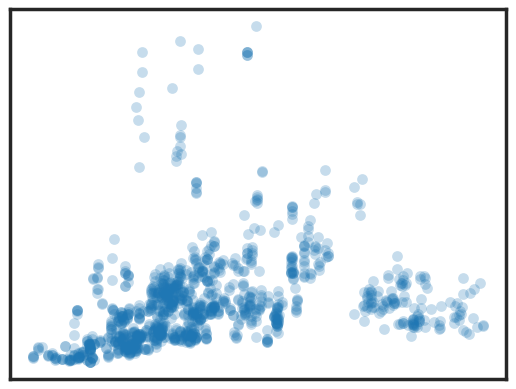

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.T[1], data.T[0], **plot_kwds)
ax.set_xticks([])
ax.set_yticks([]);

In [180]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(True)
    frame.axes.get_yaxis().set_visible(True)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=12)
    plt.text(-1.0, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=12)

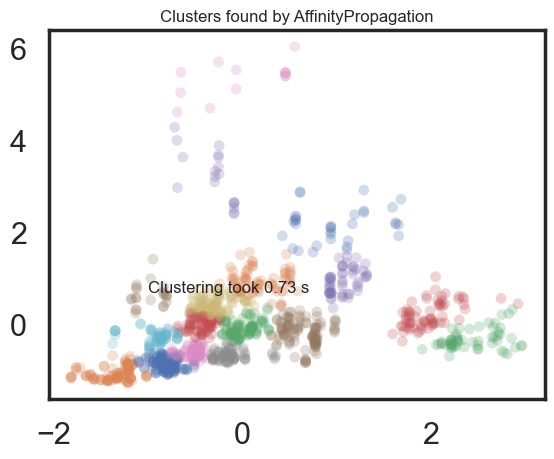

In [211]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

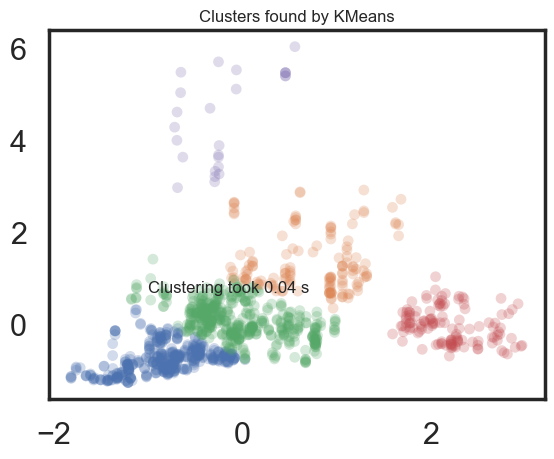

In [212]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':5})

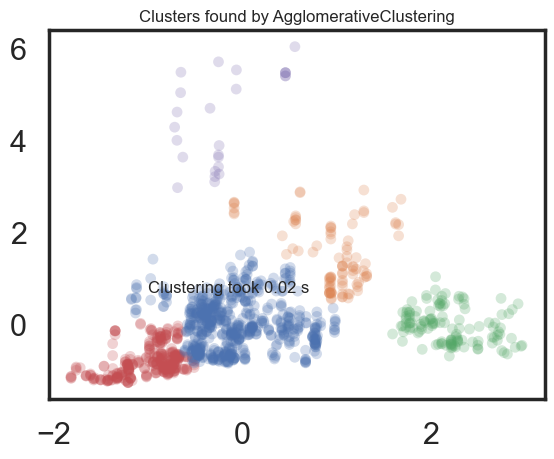

In [213]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':5, 'linkage':'ward'})

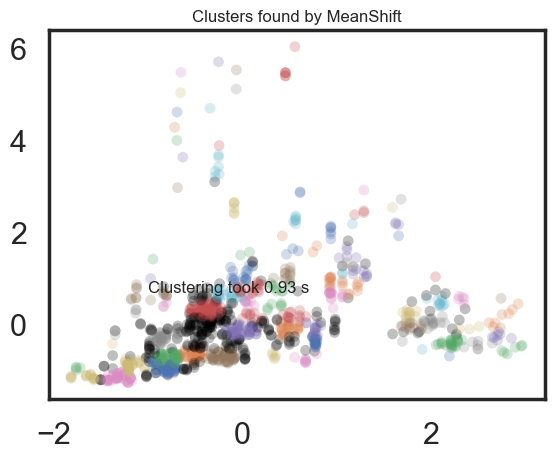

In [214]:
plot_clusters(data, cluster.MeanShift, (), {'cluster_all': False, 'bandwidth': 0.175})

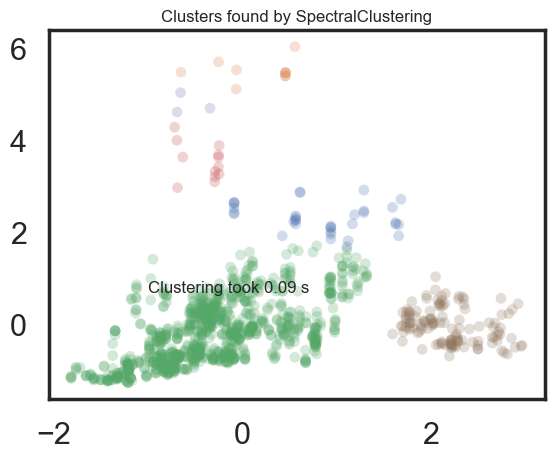

In [215]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})

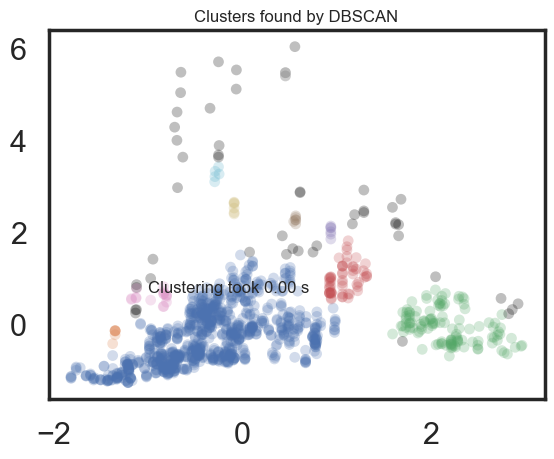

In [216]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.2})

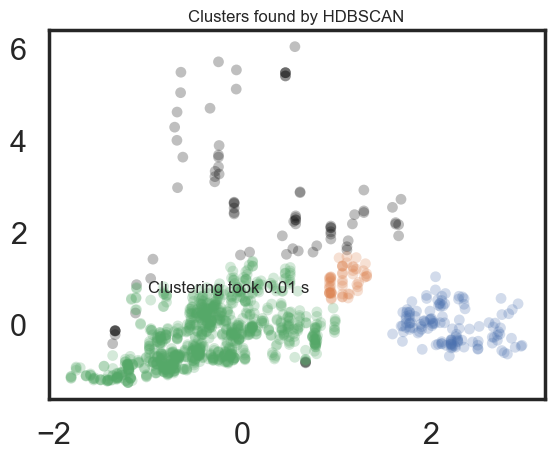

In [217]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':10})

In [218]:
labels= cluster.KMeans(n_clusters=5).fit_predict(data)

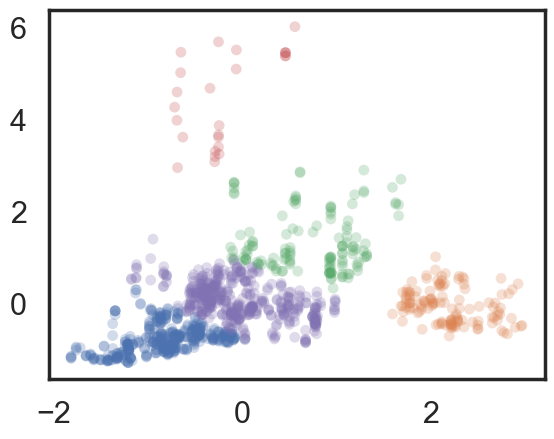

In [219]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(True)

In [220]:
df_featureeng['label'] = labels

'MSRP_WeightedByVol', 'SPEC_length_x_width'

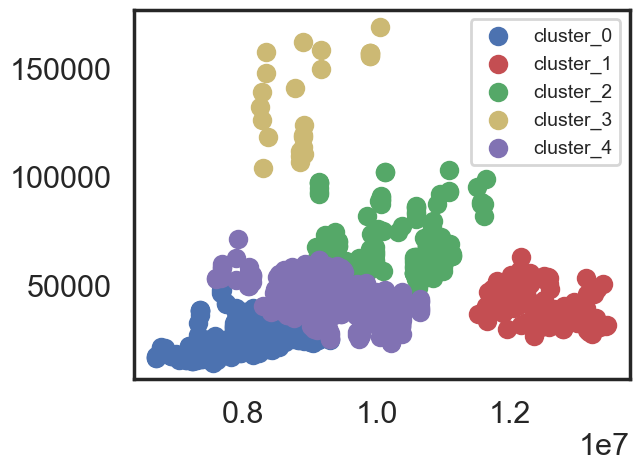

In [221]:
plt.scatter(df_featureeng[df_featureeng['label']==0]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==0]['MSRP_WeightedByVol'],c='b', label='cluster_0')
plt.scatter(df_featureeng[df_featureeng['label']==1]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==1]['MSRP_WeightedByVol'],c='r', label='cluster_1')
plt.scatter(df_featureeng[df_featureeng['label']==2]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==2]['MSRP_WeightedByVol'],c='g', label='cluster_2')
plt.scatter(df_featureeng[df_featureeng['label']==3]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==3]['MSRP_WeightedByVol'],c='y', label='cluster_3')
plt.scatter(df_featureeng[df_featureeng['label']==4]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==4]['MSRP_WeightedByVol'],c='m', label='cluster_4')
plt.legend(loc="upper right", fontsize=14) # (7)凡例表示

In [ ]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(True)

In [222]:
df_featureeng['cluster'] = labels

In [223]:
cluster_count = df_featureeng.groupby(['Segment_Name', 'cluster'])[['SPEC_MYMakeModel']].count()

In [224]:
cluster_count = cluster_count.reset_index()

In [225]:
cluster_count

Segment_Name  cluster  SPEC_MYMakeModel
0               COMPACT        0                54
1            COMPACT EV        0                69
2            COMPACT EV        4                 5
3       COMPACT LCV VAN        0                20
4       COMPACT LCV VAN        4                 7
5           COMPACT SUV        0                33
6               D Coupe        4                35
7                 ENTRY        0                60
8             ENTRY SUV        0                33
9      FULLSIZE LCV VAN        1                65
10      FULLSIZE PICKUP        1                62
11         FULLSIZE SUV        2                42
12            LARGE SUV        4                66
13        LOWER MID SUV        0                67
14        LOWER MID SUV        4                 2
15     LOWER MID SUV EV        2                 1
16     LOWER MID SUV EV        4                 7
17        LOWER MIDSIZE        0                57
18        LOWER MIDSIZE        4                 7
19   LUXURY COMPACT SUV        0                29
20   LUXURY COMPACT SUV        4                81
21  LUXURY FULLSIZE SUV        2                44
22     LUXURY LARGE SUV        2                26
23     LUXURY LARGE SUV        4                14
24           MID LUXURY        2                20
25           MID LUXURY        4                27
26       MIDSIZE PICKUP        1                 1
27       MIDSIZE PICKUP        4                50
28          MIDSIZE SUV        0                11
29          MIDSIZE SUV        4                48
30          NEAR LUXURY        0                 1
31          NEAR LUXURY        4                56
32   SPORTS/PERFORMANCE        0                10
33   SPORTS/PERFORMANCE        2                 6
34   SPORTS/PERFORMANCE        3                25
35   SPORTS/PERFORMANCE        4                29
36        UPPER MIDSIZE        4                30

In [227]:
max_rows = cluster_count.groupby('Segment_Name')[['cluster',	'SPEC_MYMakeModel']].apply(lambda x: x.loc[x['SPEC_MYMakeModel'].idxmax()])

In [228]:
max_rows

cluster  SPEC_MYMakeModel
Segment_Name                                  
COMPACT                    0                54
COMPACT EV                 0                69
COMPACT LCV VAN            0                20
COMPACT SUV                0                33
D Coupe                    4                35
ENTRY                      0                60
ENTRY SUV                  0                33
FULLSIZE LCV VAN           1                65
FULLSIZE PICKUP            1                62
FULLSIZE SUV               2                42
LARGE SUV                  4                66
LOWER MID SUV              0                67
LOWER MID SUV EV           4                 7
LOWER MIDSIZE              0                57
LUXURY COMPACT SUV         4                81
LUXURY FULLSIZE SUV        2                44
LUXURY LARGE SUV           2                26
MID LUXURY                 4                27
MIDSIZE PICKUP             4                50
MIDSIZE SUV                4                48
NEAR LUXURY                4                56
SPORTS/PERFORMANCE         4                29
UPPER MIDSIZE              4                30

In [231]:
max_rows['cluster'] = max_rows['cluster'].astype(str).replace('0', 'LowPrice_Smallsize').replace('1', 'MidPrice_Largesize').replace('4','MidPrice_Midsize').replace('2','HighPrice')

In [232]:
max_rows.groupby(['cluster']).sum()

SPEC_MYMakeModel
cluster                             
HighPrice                        112
LowPrice_Smallsize               393
MidPrice_Largesize               127
MidPrice_Midsize                 429

In [233]:
category_table = max_rows.reset_index().rename(columns={'cluster':'CATEGORY'})[['Segment_Name', 'CATEGORY']]

In [234]:
category_table

Segment_Name            CATEGORY
0               COMPACT  LowPrice_Smallsize
1            COMPACT EV  LowPrice_Smallsize
2       COMPACT LCV VAN  LowPrice_Smallsize
3           COMPACT SUV  LowPrice_Smallsize
4               D Coupe    MidPrice_Midsize
5                 ENTRY  LowPrice_Smallsize
6             ENTRY SUV  LowPrice_Smallsize
7      FULLSIZE LCV VAN  MidPrice_Largesize
8       FULLSIZE PICKUP  MidPrice_Largesize
9          FULLSIZE SUV           HighPrice
10            LARGE SUV    MidPrice_Midsize
11        LOWER MID SUV  LowPrice_Smallsize
12     LOWER MID SUV EV    MidPrice_Midsize
13        LOWER MIDSIZE  LowPrice_Smallsize
14   LUXURY COMPACT SUV    MidPrice_Midsize
15  LUXURY FULLSIZE SUV           HighPrice
16     LUXURY LARGE SUV           HighPrice
17           MID LUXURY    MidPrice_Midsize
18       MIDSIZE PICKUP    MidPrice_Midsize
19          MIDSIZE SUV    MidPrice_Midsize
20          NEAR LUXURY    MidPrice_Midsize
21   SPORTS/PERFORMANCE    MidPrice_Midsize
22        UPPER MIDSIZE    MidPrice_Midsize

Drop SPORTS/PERFORMANCE because NISSAN GTR is cluster 4 which can be outlier from the above

In [235]:
df_clean = df_clean[~(df_clean['Segment_Name']=='SPORTS/PERFORMANCE')]

Combine two table and get the Category

In [236]:
df_clean = pd.merge(df_clean, category_table, on='Segment_Name', how='left')

In [237]:
df_clean.groupby('CATEGORY')['TARGET_Weighted_RetailPrice'].count()

CATEGORY
HighPrice              985
LowPrice_Smallsize    3492
MidPrice_Largesize    3841
MidPrice_Midsize      4556
Name: TARGET_Weighted_RetailPrice, dtype: int64

In [238]:
# df_clean.to_csv('backup_df_clean_segment.csv', index=False)

In [270]:
# df_clean = pd.read_csv('backup_df_clean_segment.csv')

## Create new variables

### Previous year MSRP/RV weighted average

In [239]:
df_clean.filter(like='RV')

RV_12mo    RV_24mo    RV_36mo    RV_48mo    RV_60mo
0      75.000000  63.250000  55.583333  45.750000  37.166667
1      74.916667  63.333333  56.166667  45.833333  37.333333
2      65.077165  54.206970  45.749871  38.480615  31.291198
3      73.250000  61.083333  53.583333  44.083333  35.916667
4      65.077165  54.206970  45.749871  38.480615  31.291198
...          ...        ...        ...        ...        ...
12869  70.000000  53.000000  42.000000  31.000000  24.000000
12870  70.000000  54.000000  42.000000  32.000000  24.000000
12871  70.000000  53.000000  42.000000  31.000000  24.000000
12872  70.000000  53.000000  42.000000  31.000000  24.000000
12873  69.000000  52.000000  41.000000  31.000000  24.000000

[12874 rows x 5 columns]

In [240]:
df_temp = df_clean[['SPEC_MYMakeModel','PROFILE_Model_year','PROFILE_Make','PROFILE_Model','TARGET_Volume','TARGET_Weighted_RetailPrice', 'RV_12mo','RV_36mo', 'RV_60mo']]
df_temp['Volume_x_price'] = df_temp['TARGET_Volume'] * df_temp['TARGET_Weighted_RetailPrice']
df_temp['Volume_byMYModel'] = df_temp.groupby('SPEC_MYMakeModel')['TARGET_Volume'].transform('sum')
df_temp['Volume_index'] = df_temp['Volume_x_price'] / df_temp['Volume_byMYModel']
df_temp['MSRP_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_12mo'] = df_temp['TARGET_Volume'] * df_temp['RV_12mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_12mo'] / df_temp['Volume_byMYModel']
df_temp['RV_12mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_36mo'] = df_temp['TARGET_Volume'] * df_temp['RV_36mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_36mo'] / df_temp['Volume_byMYModel']
df_temp['RV_36mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_60mo'] = df_temp['TARGET_Volume'] * df_temp['RV_60mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_60mo'] / df_temp['Volume_byMYModel']
df_temp['RV_60mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

In [241]:
df_featureeng = df_temp.groupby(['PROFILE_Model_year',\
                                 'PROFILE_Make','PROFILE_Model','SPEC_MYMakeModel'])\
[['MSRP_WeightedByVol', 'RV_12mo_WeightedByVol', 'RV_36mo_WeightedByVol', 'RV_60mo_WeightedByVol']].mean().reset_index()

In [242]:
df_featureeng = df_featureeng.sort_values(by=['PROFILE_Model', 'PROFILE_Model_year'], ascending=[1,1]).reset_index()

Filling out the values with previous year's values

In [243]:
grouped = df_featureeng.groupby('PROFILE_Model')
df_featureeng['MSRP_prevMY_WeightedByVol'] = grouped['MSRP_WeightedByVol'].shift(1)
df_featureeng['MSRP_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['MSRP_WeightedByVol'] \
                        if pd.isna(x['MSRP_prevMY_WeightedByVol']) else x['MSRP_prevMY_WeightedByVol'],axis=1)

In [244]:
df_featureeng['RV_12mo_prevMY_WeightedByVol'] = grouped['RV_12mo_WeightedByVol'].shift(1)
df_featureeng['RV_12mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_12mo_WeightedByVol'] \
                        if pd.isna(x['RV_12mo_prevMY_WeightedByVol']) else x['RV_12mo_prevMY_WeightedByVol'],axis=1)

In [245]:
df_featureeng['RV_36mo_prevMY_WeightedByVol'] = grouped['RV_36mo_WeightedByVol'].shift(1)
df_featureeng['RV_36mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_36mo_WeightedByVol'] \
                        if pd.isna(x['RV_36mo_prevMY_WeightedByVol']) else x['RV_36mo_prevMY_WeightedByVol'],axis=1)

In [249]:
df_featureeng['RV_60mo_prevMY_WeightedByVol'] = grouped['RV_60mo_WeightedByVol'].shift(1)
df_featureeng['RV_60mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_60mo_WeightedByVol'] \
                        if pd.isna(x['RV_60mo_prevMY_WeightedByVol']) else x['RV_60mo_prevMY_WeightedByVol'],axis=1)

In [250]:
df_featureeng

index  PROFILE_Model_year PROFILE_Make PROFILE_Model SPEC_MYMakeModel  \
0        68                2015         AUDI            A4     2015_AUDI_A4   
1       180                2016         AUDI            A4     2016_AUDI_A4   
2       293                2017         AUDI            A4     2017_AUDI_A4   
3       416                2018         AUDI            A4     2018_AUDI_A4   
4       540                2019         AUDI            A4     2019_AUDI_A4   
...     ...                 ...          ...           ...              ...   
1125    582                2019          GMC         YUKON   2019_GMC_YUKON   
1126    703                2020          GMC         YUKON   2020_GMC_YUKON   
1127    827                2021          GMC         YUKON   2021_GMC_YUKON   
1128    947                2022          GMC         YUKON   2022_GMC_YUKON   
1129   1061                2023          GMC         YUKON   2023_GMC_YUKON   

      MSRP_WeightedByVol  RV_12mo_WeightedByVol  RV_36mo_WeightedByVol  \
0           38183.815887              64.582664              43.118283   
1           38378.633836              62.582960              44.046160   
2           40369.253898              59.964344              44.049823   
3           42986.854589              59.371452              40.773757   
4           44776.081026              57.198286              38.610747   
...                  ...                    ...                    ...   
1125        63373.357840              62.465389              48.964999   
1126        62703.836746              64.599672              51.043442   
1127        66196.828103              74.895240              53.142705   
1128        66973.164070              80.059720              54.270227   
1129        72204.357662              79.713361              54.094722   

      RV_60mo_WeightedByVol  MSRP_prevMY_WeightedByVol  \
0                 30.653281               38183.815887   
1                 30.468371               38183.815887   
2                 31.092499               38378.633836   
3                 28.831883               40369.253898   
4                 26.401589               42986.854589   
...                     ...                        ...   
1125              33.675458               63110.984107   
1126              33.901986               63373.357840   
1127              34.062266               62703.836746   
1128              34.651322               66196.828103   
1129              34.770770               66973.164070   

      RV_12mo_prevMY_WeightedByVol  RV_36mo_prevMY_WeightedByVol  \
0                        64.582664                     43.118283   
1                        64.582664                     43.118283   
2                        62.582960                     44.046160   
3                        59.964344                     44.049823   
4                        59.371452                     40.773757   
...                            ...                           ...   
1125                     59.981785                     47.121872   
1126                     62.465389                     48.964999   
1127                     64.599672                     51.043442   
1128                     74.895240                     53.142705   
1129                     80.059720                     54.270227   

      RV_60mo_prevMY_WeightedByVol  
0                        30.653281  
1                        30.653281  
2                        30.468371  
3                        31.092499  
4                        28.831883  
...                            ...  
1125                     33.255234  
1126                     33.675458  
1127                     33.901986  
1128                     34.062266  
1129                     34.651322  

[1130 rows x 13 columns]

In [271]:
df_clean = pd.merge(df_clean, df_featureeng[['SPEC_MYMakeModel', 'MSRP_prevMY_WeightedByVol',
                                  'RV_12mo_prevMY_WeightedByVol']], on='SPEC_MYMakeModel', how='left')

In [253]:
df_clean.filter(like='Segment').columns

Index(['Segment_Competing_Nissan_Model', 'Segment_Name', 'Segment_COMPACT',
       'Segment_COMPACT_EV', 'Segment_COMPACT_LCV_VAN', 'Segment_COMPACT_SUV',
       'Segment_D_Coupe', 'Segment_ENTRY', 'Segment_ENTRY_SUV',
       'Segment_FULLSIZE_LCV_VAN', 'Segment_FULLSIZE_PICKUP',
       'Segment_FULLSIZE_SUV', 'Segment_LARGE_SUV', 'Segment_LOWER_MID_SUV',
       'Segment_LOWER_MID_SUV_EV', 'Segment_LOWER_MIDSIZE',
       'Segment_LUXURY_COMPACT_SUV', 'Segment_LUXURY_FULLSIZE_SUV',
       'Segment_LUXURY_LARGE_SUV', 'Segment_MID_LUXURY',
       'Segment_MIDSIZE_PICKUP', 'Segment_MIDSIZE_SUV', 'Segment_NEAR_LUXURY',
       'Segment_SPORTS_PERFORMANCE', 'Segment_UPPER_MIDSIZE'],
      dtype='object')

In [272]:
drop_lst = ['PROFILE_Name', 'PROFILE_Unique_Identity', 'PROFILE_Data_date',
      'PROFILE_Version_state', 'PROFILE_Data_status', 
      'PROFILE_Model', 'PROFILE_Version_name',
      'PROFILE_Trim_level', 'PROFILE_Number_of_doors', 
      'PROFILE_Vehicle_type', 'PROFILE_JATO_global_segment',
      'PROFILE_JATO_regional_segment', 'PROFILE_Model_year','PROFILE_Make','PROFILE_Body_type',
      'TARGET_Retail_price_including_delivery_charge',
      'TARGET_Retail_price',  'Segment_Competing_Nissan_Model', 
      'SPEC_Compressor_supercharger','Segment_Name', 'SPEC_MYMakeModel',
      'Segment_Name', 'Segment_SPORTS_PERFORMANCE', 'SPEC_overall_width_mm',
      'SPEC_overall_length_mm','SPEC_maximum_torque_lb_ft']

In [273]:
df_clean = df_clean.drop(drop_lst, axis=1)

In [274]:
pd.DataFrame(df_clean.isna().sum(), columns=['null_number']).sort_values(by='null_number', ascending=False)

null_number
SPEC_Special_edition                         0
SPEC_ManualTransmission                      0
SPEC_roof_semi_high                          0
SPEC_roof_high                               0
SPEC_roof_standard                           0
...                                        ...
SPEC_includes_collision_avoidance            0
SPEC_Active_seatback                         0
SPEC_Autonomous_drive                        0
SPEC_overtaking                              0
RV_12mo_prevMY_WeightedByVol                 0

[1105 rows x 1 columns]

In [267]:
df_clean['CATEGORY'].unique()

array(['HighPrice', 'MidPrice_Midsize', 'LowPrice_Smallsize',
       'MidPrice_Largesize'], dtype=object)

In [341]:
df_clean.to_csv('../01_Outputs/modeling_2nd/df_model.csv', index=False)

In [275]:
df_model_HighPrice = df_clean[df_clean['CATEGORY'] =='HighPrice'].drop('CATEGORY', axis=1)
df_model_MidPrice_Midsize = df_clean[df_clean['CATEGORY'] =='MidPrice_Midsize'].drop('CATEGORY', axis=1)
df_model_LowPrice_Smallsize = df_clean[df_clean['CATEGORY'] =='LowPrice_Smallsize'].drop('CATEGORY', axis=1)
df_model_MidPrice_Largesize = df_clean[df_clean['CATEGORY'] =='MidPrice_Largesize'].drop('CATEGORY', axis=1)

# Non Linear model -> P-Values

## LowPrice_Smallsize

In [374]:
df = df_model_LowPrice_Smallsize.copy()

In [375]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [376]:
len(df)

3492

In [377]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_Audio_system
SPEC_in_dash_DVD
SPEC_Audio_zones
SPEC_Conversation_enhancement
SPEC_Rear_separate_audio_control
SPEC_Disc_player
SPEC_HDMI_connection_rear
SPEC_AUX_jack_rear
SPEC_game_console_rear
SPEC_surface_coating
SPEC_Height_adjustable_pedals
SPEC_Ceramic_brakes
SPEC_Brake_assist_with_preview
SPEC_sliding_anchorage_points
SPEC_Pickup_bed
SPEC_side_doors
SPEC_logo_projection
SPEC_includes_augmented_reality
SPEC_touch_pad
SPEC_mouse
SPEC_Fleet_telematics
SPEC_connected_rear_seat_entertainment
SPEC_head_restraint
SPEC_pedals
SPEC_Trailer_assist
SPEC_automatic_steering
SPEC_trailer_reversing_aid
SPEC_trailer_hitch_assist
SPEC_trailer_brake_control
SPEC_Facial_gesture_control
SPEC_Wade_sensing
SPEC_Internal_dimensions
SPEC_Cargo_capacity
SPEC_Doors
SPEC_Multi_function_tailgate
SPEC_Exterior_door_handles
SPEC_Mode_3_charging_cable
SPEC_Smart_charging
SPEC_Instrument_panel
SPEC_HUD_inc_augmented_reality
SPEC_illuminated367
SPEC_fog_light_function
SPEC_digital_matrix
SPEC

In [378]:
len(drop_lst)

244

In [379]:
df = df.drop(drop_lst, axis=1)

In [380]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 3492
SPEC_Wheelbase_ 3492
SPEC_Drivenwheels_ 3492
SPEC_fueltype_ 3492
SPEC_Seatmaterial_ 3492
SPEC_Continentgroup_ 3492
SPEC_CountryOfAssembly_ 3492
PROFILE_MY_ 3492
PROFILE_Make_ 3492
PROFILE_Bodytype_ 3492
Segment_ 3492


Duplicated dummy variable

In [ ]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [ ]:
# df = df.drop(dupli_cols, axis=1)

In [381]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [382]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [383]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [384]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 3492
Model:                                     GLM   Df Residuals:                     2724
Model Family:                            Gamma   Df Model:                          767
Link Function:                             log   Scale:                      0.00042147
Method:                                   IRLS   Log-Likelihood:                -26410.
Date:                         Wed, 05 Jul 2023   Deviance:                       1.1464
Time:                                 22:37:25   Pearson chi2:                     1.15
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -2.1662      0.405     -5.347      0.000      -2.960      -1.372
SPEC_DC1socket[T.True]                                    -0.0209      0.021     -0.982      0.326      -0.063       0.021
SPEC_AC1socket[T.True]                                     0.0338      0.018      1.895      0.058      -0.001       0.069
SPEC_fueltype_electric                                    -0.4609      0.086     -5.368      0.000      -0.629      -0.293
SPEC_Ion_filtering                                         0.0200      0.021      0.942      0.346      -0.022       0.062
SPEC_includes_phone                                        0.0553      0.049      1.124      0.261      -0.041       0.152
SPEC_Enginetype_combustion                                -1.3491      0.254     -5.321      0.000      -1.846      -0.852
SPEC_RRseatbelt_pretentioners                             -0.0142      0.009     -1.577      0.115      -0.032       0.003
SPEC_fueltype_premium_unleaded                            -0.4332      0.073     -5.975      0.000      -0.575      -0.291
PROFILE_MY_2020                                           -0.1872      0.038     -4.924      0.000      -0.262      -0.113
SPEC_holder                                                0.0081      0.009      0.946      0.344      -0.009       0.025
SPEC_headroom_front_mm                                     0.0003    7.3e-05      3.822      0.000       0.000       0.000
SPEC_average_fuel_consumption                              0.0030      0.015      0.193      0.847      -0.027       0.033
SPEC_location_sharing146                                  -0.0010      0.012     -0.088      0.930      -0.024       0.022
PROFILE_Make_SUBARU                                       -0.2099      0.043     -4.853      0.000      -0.295      -0.125
SPEC_Drivenwheels_4x4                                     -0.4264      0.084     -5.074      0.000      -0.591      -0.262
SPEC_IIHS_roofstrength_Good                               -0.0361      0.011     -3.407      0.001      -0.057      -0.015
SPEC_wheelbase_short                                      -1.0812      0.203     -5.337      0.000      -1.478      -0.684
SPEC_multi_function                                       -0.0164      0.007     -2.482      0.013      -0.029      -0.003
SPEC_FRPGseat_reclining_memory                            -0.2628      0.051     -5.165      0.000      -0.363      -0.163
SPEC_multi_touch_screen136                                 0.0106      0.004      2.749      0.006       0.003       0.018
SPEC_Entertainment_display_scree

In [385]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
significant_values.remove('Intercept')

In [386]:
df_model_pvalue = df[significant_values]

In [387]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [388]:
len(df_model_pvalue.columns)

417

In [389]:
len(category_vars)

362

In [390]:
len(numerical_vars)

55

In [391]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [392]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [393]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [394]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [395]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [396]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

variable         pvalue  \
47                      SPEC_published_kerb_weight_kg   0.000000e+00   
39                          MSRP_prevMY_WeightedByVol   0.000000e+00   
15                             SPEC_maximum_torque_Nm   0.000000e+00   
18                        SPEC_wheelrim_diameter_inch   0.000000e+00   
21                            SPEC_tire_diameter_inch   0.000000e+00   
11                           SPEC_wheelrim_width_inch  4.141456e-318   
29                        SPEC_shoulder_room_front_mm  4.676310e-242   
40                            SPEC_motorpowerkW_total  1.385492e-216   
3                                 SPEC_length_x_width  6.106149e-208   
27             SPEC_multifuncdisplay_Instrument1_size  2.775336e-166   
35                           SPEC_motortorquelbft_max  8.719135e-163   
44                             SPEC_motortorqueNm_max  8.737595e-163   
14                                          MACRO_GDP  1.921051e-107   
31                                        SPEC_numUSB   3.782065e-90   
16                            SPEC_headrestraints_num   8.162089e-85   
48                                      SPEC_Seat_num   8.162089e-85   
20                              SPEC_numchargingcable   8.162089e-85   
17         SPEC_total_number_of_USB_connections_front   1.265657e-82   
52                             SPEC_overall_height_mm   4.374569e-65   
32                          SPEC_payload_allowance_kg   2.104736e-49   
30                                      SPEC_width_mm   1.060231e-28   
51                             SPEC_Number_of_doors32   1.756513e-25   
19                                            RV_24mo   2.795532e-22   
4                   SPEC_width_between_wheelhouses_mm   3.086833e-21   
8                        SPEC_loading_floor_height_mm   9.493136e-18   
50                                            RV_60mo   5.664603e-13   
5                    Edmunds_DP_Ridecomfortsentiscore   1.472673e-11   
46                           SPEC_duration_months1016   3.301379e-11   
38                      NCBS_OVERALL_Power_And_Pickup   4.953185e-10   
41                                     SPEC_length_mm   2.328854e-07   
6                                 SPEC_Airbags_number   1.036765e-06   
13                                Edmunds_Star_Rating   3.347288e-06   
54                   Edmunds_ExteriorDesignsentiscore   9.562670e-05   
53               SPEC_entertainmentscreen_biggestsize   9.891669e-05   
12                              SPEC_Seating_capacity   1.109461e-01   
7                                         SPEC_Liters   1.968591e-01   
34                                            SPEC_cc   1.975849e-01   
0                              SPEC_headroom_front_mm   4.076166e-01   
42                    Edmunds_Infortainmentsentiscore   1.329163e-04   
37                   NCBS_OVERALL_Driving_Performance   9.038255e-05   
36                         SPEC_local_number_of_doors   1.034420e-05   
25                               SPEC_distance_km1008   9.089345e-06   
1                            SPEC_duration_months1007   7.842929e-06   
26                                      TARGET_Volume   1.447330e-06   
28                         SPEC_CurtainAirbag_numRows   1.162872e-12   
22                           SPEC_duration_months1010   2.876712e-13   
43  NCBS_OVERALL_Interior_Versatility_Seat_Configu...   2.963215e-15   
2   NCBS_OVERALL_Performance_of_Climate_Control_Sy...   2.387284e-19   
49                               SPEC_distance_km1011   1.255197e-23   
9                           SPEC_assisthandles_number   2.168246e-37   
45                                          SPEC_bore   4.582681e-53   
10                             SPEC_compression_ratio   4.462639e-60   
23                                        SPEC_stroke   2.296336e-73   
24                    SPEC_rpm_for_maximum_torque_low  1.166658e-119   
33                 SPEC_number_of_valves_per_cylinder  1.530228e-134   

    correlat

In [397]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [398]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [399]:
final_features = list(set(categorical).union(numerical))

In [400]:
len(final_features)

343

In [401]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [402]:
df_model_pvalue.to_csv('../01_Outputs/modeling_2nd/df_model_LowPrice_Smallsize.csv', index=False)

## MidPrice_Midsize

In [342]:
df = df_model_MidPrice_Midsize.copy()

In [343]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [344]:
len(df)

4556

In [345]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_HDMI_connection_front
SPEC_AUX_jack_rear
SPEC_surface_coating
SPEC_Fleet_telematics
SPEC_automatic_steering
SPEC_MirrorLink
SPEC_Mirrorlink_wireless_connection
SPEC_Internal_dimensions
SPEC_Doors
SPEC_Multi_function_tailgate
SPEC_Block_heater
SPEC_Instrument_panel
SPEC_Low_tire_pressure_indicator
SPEC_digital_matrix
SPEC_Clearance_lights
SPEC_multi_coat
SPEC_Front_airbag
SPEC_Head_restraints
SPEC_Isofix_preparation
SPEC_seat_vibrate
SPEC_Seating
SPEC_Seat_upholstery
SPEC_Front_seat
SPEC_electrically_adjustable817
SPEC_climate_controlled826
SPEC_active_massage827
SPEC_removable840
SPEC_Fourth_row_seats
SPEC_Fifth_row_seats
SPEC_Electronic_traction_control
SPEC_Stability_control
SPEC_Ventilation_system
SPEC_intelligent939
SPEC_Door_mirrors_cameras
SPEC_Opening_rear_1_4_windows
SPEC_remote_control_operation
SPEC_Rear_window
SPEC_Windshield_wipers
SPEC_Trailer_towing_mirrors
SPEC_4th_row_windows
SPEC_Night_vision
SPEC_Warranty_whole_vehicle___Dealer
SPEC_Warranty_powertr

In [346]:
len(drop_lst)

145

In [347]:
df = df.drop(drop_lst, axis=1)

In [348]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 4556
SPEC_Wheelbase_ 4556
SPEC_Drivenwheels_ 4556
SPEC_fueltype_ 4556
SPEC_Continentgroup_ 4556
SPEC_CountryOfAssembly_ 4556
PROFILE_MY_ 4556
PROFILE_Make_ 4556
PROFILE_Bodytype_ 4556
Segment_ 4556


Duplicated dummy variable

In [ ]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [ ]:
# df = df.drop(dupli_cols, axis=1)

In [349]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [350]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [351]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [352]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 4556
Model:                                     GLM   Df Residuals:                     3686
Model Family:                            Gamma   Df Model:                          869
Link Function:                             log   Scale:                      0.00070137
Method:                                   IRLS   Log-Likelihood:                -38035.
Date:                         Wed, 05 Jul 2023   Deviance:                       2.5671
Time:                                 22:31:37   Pearson chi2:                     2.59
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  1.1730      0.039     29.732      0.000       1.096       1.250
SPEC_DC1socket[T.True]                                     0.8830      0.031     28.542      0.000       0.822       0.944
SPEC_AC1socket[T.True]                                     0.0130      0.014      0.896      0.370      -0.015       0.041
SPEC_fueltype_electric                                     0.3161      0.011     28.170      0.000       0.294       0.338
SPEC_towingclass_IV                                        0.0200      0.009      2.341      0.019       0.003       0.037
SPEC_Ion_filtering                                         0.0080      0.009      0.933      0.351      -0.009       0.025
SPEC_includes_phone                                       -0.0378      0.013     -2.863      0.004      -0.064      -0.012
SPEC_Enginetype_combustion                                 0.6372      0.022     29.465      0.000       0.595       0.680
PROFILE_Make_INFINITI                                      0.0359      0.033      1.073      0.283      -0.030       0.102
SPEC_FRPGseat_thighsupport_memory                         -0.0191      0.012     -1.570      0.116      -0.043       0.005
PROFILE_Make_MERCEDES                                      0.1443      0.041      3.528      0.000       0.064       0.225
SPEC_fueltype_premium_unleaded                             0.2031      0.013     15.973      0.000       0.178       0.228
PROFILE_MY_2020                                            0.1018      0.009     11.151      0.000       0.084       0.120
SPEC_RRseatbelt_pretentioners                              0.0148      0.018      0.805      0.421      -0.021       0.051
SPEC_holder                                                0.0119      0.006      1.904      0.057      -0.000       0.024
SPEC_headroom_front_mm                                    -0.0003   4.43e-05     -6.807      0.000      -0.000      -0.000
SPEC_average_fuel_consumption                              0.0720      0.047      1.535      0.125      -0.020       0.164
SPEC_Drivenwheels_4x4                                      0.4559      0.016     29.290      0.000       0.425       0.486
SPEC_location_sharing146                                   0.0256      0.021      1.208      0.227      -0.016       0.067
SPEC_IIHS_roofstrength_Good                                0.0078      0.008      0.946      0.344      -0.008       0.024
SPEC_wheelbase_short                                       0.3735      0.014     27.607      0.000       0.347       0.400
SPEC_multi_function             

In [355]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
significant_values.remove('Intercept')
significant_values.remove('SPEC_DC1socket[T.True]')
significant_values.append('SPEC_DC1socket')

In [356]:
df_model_pvalue = df[significant_values]

In [357]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [358]:
len(df_model_pvalue.columns)

389

In [359]:
len(category_vars)

348

In [360]:
len(numerical_vars)

41

In [361]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [362]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [363]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [364]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [365]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [366]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

variable         pvalue  correlation
33                  MSRP_prevMY_WeightedByVol   0.000000e+00     0.791756
10                     SPEC_maximum_torque_Nm   0.000000e+00     0.790622
8                    SPEC_wheelrim_width_inch   0.000000e+00     0.722272
14                SPEC_wheelrim_diameter_inch   0.000000e+00     0.540303
15                    SPEC_tire_diameter_inch   0.000000e+00     0.540303
16                        SPEC_screen_size_in  2.001440e-193     0.419240
31              NCBS_OVERALL_Power_And_Pickup  8.519041e-152     0.374655
18                   NCBS_OVERALL_Brand_Image  1.507344e-138     0.358872
26     NCBS_OVERALL_Noise_Vibration_Harshness  3.148361e-118     0.332763
20         NCBS_OVERALL_Safety_of_the_Vehicle  2.662941e-104     0.313276
36                 SPEC_transmission_numspeed   2.185908e-75     0.267297
4                     MACRO_Average_MSRP_spec   2.432194e-45     0.207142
23                  MACRO_Average_MSRP_spec_1   2.432194e-45     0.207142
12  SPEC_multifuncdisplay_nummultitouchscreen   2.397446e-44     0.204818
40       SPEC_entertainmentscreen_biggestsize   8.018113e-36     0.183581
9       SPEC_multifuncdisplay_Dashboard2_size   1.509349e-27     0.160125
39              SPEC_published_kerb_weight_kg   3.095385e-20     0.135934
28                                SPEC_numUSB   1.991980e-19     0.132983
30                                    SPEC_cc   1.629114e-13     0.108984
5                         SPEC_Airbags_number   4.639630e-07     0.074595
27    NCBS_OVERALL_Environmental_Friendliness   2.608996e-06     0.069558
37            Edmunds_Infortainmentsentiscore   1.393063e-03     0.047337
25                                SPEC_amount   4.341006e-01     0.011591
34           Edmunds_FuelEfficiencysentiscore   1.990083e-02    -0.034492
1            NCBS_OVERALL_Value_For_The_Money   1.053326e-02    -0.037891
7                      SPEC_compression_ratio   8.708458e-15    -0.114572
22                                  MACRO_CCI   8.129660e-16    -0.118905
13             SPEC_rpm_for_maximum_power_low   6.293027e-22    -0.141908
35                            SPEC_axle_ratio   6.643078e-38    -0.189002
38                                  SPEC_bore   6.030215e-44    -0.203873
19                              TARGET_Volume   7.770274e-56    -0.230150
32                         SPEC_capacity_l289   5.560746e-56    -0.230451
6                   SPEC_assisthandles_number   3.584922e-57    -0.232900
24                SPEC_shoulder_room_front_mm   7.167917e-72    -0.261056
0                      SPEC_headroom_front_mm   8.380732e-91    -0.292873
2                         SPEC_length_x_width  3.545196e-124    -0.340669
21                                  Inventory  1.476666e-142    -0.363742
17            SPEC_rpm_for_maximum_torque_low  3.813030e-173    -0.398376
3           SPEC_width_between_wheelhouses_mm  1.459872e-174    -0.399883
11                                    RV_36mo  3.265275e-218    -0.442884
29                  SPEC_payload_allowance_kg  4.843248e-254    -0.474054

In [367]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [368]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [369]:
final_features = list(set(categorical).union(numerical))

In [370]:
len(final_features)

333

In [371]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [372]:
df_model_pvalue

SPEC_fueltype_electric  SPEC_towingclass_IV  PROFILE_Bodytype_coupe  \
82                          0                    0                       0   
83                          0                    0                       0   
84                          0                    0                       0   
85                          0                    0                       0   
86                          0                    0                       0   
...                       ...                  ...                     ...   
12503                       0                    1                       0   
12504                       0                    1                       0   
12505                       0                    1                       0   
12506                       0                    1                       0   
12507                       0                    1                       0   

       SPEC_includes_phone  SPEC_IIHS_roofstrength_Marginal  \
82                       1                                0   
83                       1                                0   
84                       1                                0   
85                       1                                0   
86                       1                                0   
...                    ...                              ...   
12503                    1                                0   
12504                    1                                0   
12505                    1                                0   
12506                    1                                0   
12507                    1                                0   

       SPEC_Enginetype_combustion  SPEC_extdoorhundle_black  \
82                              1                         0   
83                              1                         0   
84                              1                         0   
85                              1                         0   
86                              1                         0   
...                           ...                       ...   
12503                           1                         0   
12504                           1                         0   
12505                           1                         0   
12506                           1                         0   
12507                           1                         0   

       PROFILE_Make_MERCEDES  SPEC_fueltype_premium_unleaded  \
82                         0                               1   
83                         0                               1   
84                         0                               1   
85                         0                               1   
86                         0                               1   
...                      ...                             ...   
12503                      0                               0   
12504                      0                               0   
12505                      0                               0   
12506                      0                               0   
12507                      0                               0   

       SPEC_headroom_front_mm  ...  SPEC_fueltype_diesel  \
82                      983.0  ...                     0   
83                      983.0  ...                     0   
84                      983.0  ...                     0   
85                      983.0  ...                     0   
86                      983.0  ...                     0   
...                       ...  ...                   ...   
12503                  1008.0  ...                     0   
12504                  1008.0  ...                     0   
12505                  1008.0  ...                     0   
12506                  1008.0  ...                     0   
12507                  1008.0  ...                     0   

       SPEC_FRDRseat_tilt_memory  SPEC_Luxury_inner_roof_upholster

In [373]:
df_model_pvalue.to_csv('../01_Outputs/modeling_2nd/df_model_MidPrice_Midsize.csv', index=False)

## MidPrice_Largesize

In [403]:
df = df_model_MidPrice_Largesize.copy()

In [404]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [405]:
len(df)

3841

In [406]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Special_edition
SPEC_Limited_edition
SPEC_wireless_headphones
SPEC_in_dash_DVD
SPEC_Audio_zones
SPEC_Conversation_enhancement
SPEC_HDMI_connection_front
SPEC_HDMI_connection_rear
SPEC_AUX_jack_rear
SPEC_game_console_rear
SPEC_Spoiler
SPEC_Sport_exhaust_pipe
SPEC_driver_controlled_valve_flap
SPEC_painted_callipers
SPEC_surface_coating
SPEC_Ceramic_brakes
SPEC_Cornering_brake_control
SPEC_Cargo_area_cover_rear_parcel_shelf
SPEC_Price_includes
SPEC_memory
SPEC_Hands_free_boot_release
SPEC_side_doors
SPEC_logo_projection
SPEC_adaptive_cruise_cont_linked_to_mapping
SPEC_Intelligent_speed_assistance
SPEC_includes_augmented_reality
SPEC_touch_pad
SPEC_mouse
SPEC_Ambient_lighting_colour_selection
SPEC_Ambient_lighting_wrap_around
SPEC_tow_away_alert
SPEC_remote_seat_heating_control
SPEC_Connected_camera
SPEC_Online_entertainment
SPEC_connected_rear_seat_entertainment
SPEC_antenna160
SPEC_Entertainment_display_screen
SPEC_head_restraint
SPEC_Internet_connection
SPEC_DVD_VCD
SPEC_Blind_junc

In [407]:
len(drop_lst)

319

In [408]:
df = df.drop(drop_lst, axis=1)

In [409]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 3841
SPEC_Wheelbase_ 3841
SPEC_Drivenwheels_ 3841
SPEC_fueltype_ 3841
SPEC_Continentgroup_ 3841
SPEC_CountryOfAssembly_ 3841
PROFILE_MY_ 3841
PROFILE_Make_ 3841
PROFILE_Bodytype_ 3841
Segment_ 3841


Duplicated dummy variable

In [410]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [411]:
# df = df.drop(dupli_cols, axis=1)

In [412]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [413]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [414]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [415]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 3841
Model:                                     GLM   Df Residuals:                     3209
Model Family:                            Gamma   Df Model:                          631
Link Function:                             log   Scale:                      0.00036176
Method:                                   IRLS   Log-Likelihood:                -30651.
Date:                         Wed, 05 Jul 2023   Deviance:                       1.1592
Time:                                 22:38:50   Pearson chi2:                     1.16
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0140      0.002      8.074      0.000       0.011       0.017
SPEC_DC1socket[T.True]                                    -0.0578      0.023     -2.502      0.012      -0.103      -0.013
SPEC_AC1socket[T.True]                                    -0.0578      0.023     -2.502      0.012      -0.103      -0.013
SPEC_fueltype_electric                                     0.0146      0.014      1.069      0.285      -0.012       0.041
SPEC_towingclass_IV                                       -0.0086      0.007     -1.259      0.208      -0.022       0.005
SPEC_dual_rear_wheel                                      -0.0078      0.005     -1.691      0.091      -0.017       0.001
SPEC_includes_phone                                       -0.0269      0.023     -1.192      0.233      -0.071       0.017
SPEC_Enginetype_combustion                                 0.0120      0.007      1.637      0.102      -0.002       0.026
PROFILE_Make_MERCEDES                                      0.0973      0.031      3.184      0.001       0.037       0.157
SPEC_fueltype_premium_unleaded                             0.0073      0.008      0.872      0.383      -0.009       0.024
PROFILE_MY_2020                                           -0.0738      0.017     -4.276      0.000      -0.108      -0.040
SPEC_holder                                               -0.0514      0.047     -1.085      0.278      -0.144       0.041
SPEC_headroom_front_mm                                 -2.567e-05   1.13e-05     -2.267      0.023   -4.79e-05   -3.47e-06
SPEC_average_fuel_consumption                             -0.0002      0.004     -0.041      0.967      -0.008       0.007
SPEC_location_sharing146                                   0.0497      0.051      0.983      0.325      -0.049       0.149
SPEC_Drivenwheels_4x4                                      0.0309      0.035      0.870      0.384      -0.039       0.100
SPEC_IIHS_roofstrength_Good                               -0.0053      0.025     -0.213      0.831      -0.054       0.043
SPEC_wheelbase_short                                       0.0044      0.001      5.286      0.000       0.003       0.006
SPEC_multi_function                                       -0.0148      0.007     -2.266      0.023      -0.028      -0.002
SPEC_multi_touch_screen136                                -0.0106      0.013     -0.802      0.422      -0.036       0.015
SPEC_Readinglight_FR                                      -0.0060      0.005     -1.217      0.223      -0.016       0.004
NCBS_OVERALL_Value_For_The_Money

In [418]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
significant_values.remove('Intercept')
significant_values.remove('SPEC_AC1socket[T.True]')
significant_values.remove('SPEC_DC1socket[T.True]')
significant_values.append('SPEC_AC1socket')
significant_values.append('SPEC_DC1socket')

In [419]:
df_model_pvalue = df[significant_values]

In [420]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [421]:
len(df_model_pvalue.columns)

304

In [422]:
len(category_vars)

260

In [423]:
len(numerical_vars)

44

In [424]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [425]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [426]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [427]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [428]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [429]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

variable         pvalue  \
9                       SPEC_Autoairconditioner_zones   0.000000e+00   
33                          MSRP_prevMY_WeightedByVol   0.000000e+00   
41                             SPEC_Number_of_doors32  5.562129e-201   
31                         SPEC_local_number_of_doors  5.562129e-201   
32                                    MACRO_Inflation  1.176155e-190   
20                                        SPEC_amount  3.273695e-173   
7          SPEC_total_number_of_USB_connections_front  1.139024e-168   
10                                            RV_24mo   2.265656e-69   
6                              SPEC_compression_ratio   2.464319e-60   
30                           SPEC_motortorquelbft_max   7.199634e-39   
38                             SPEC_motortorqueNm_max   7.722008e-39   
2                                 SPEC_length_x_width   4.597628e-31   
43                   Edmunds_ExteriorDesignsentiscore   2.370524e-28   
24                                     SPEC_height_mm   8.016927e-20   
0                              SPEC_headroom_front_mm   1.662171e-15   
40                           SPEC_duration_months1016   2.484119e-15   
29                   Edmunds_InteriorDesignsentiscore   1.594981e-10   
42                             SPEC_overall_height_mm   4.132472e-08   
35                                     SPEC_length_mm   1.577977e-07   
36              NCBS_OVERALL_Interior_Design___Layout   9.239587e-07   
34                   Edmunds_FuelEfficiencysentiscore   3.724503e-06   
12                      NCBS_OVERALL_Exterior_Styling   1.789954e-05   
22             NCBS_OVERALL_Noise_Vibration_Harshness   4.674248e-04   
4                        SPEC_loading_floor_height_mm   3.463887e-02   
16                                      TARGET_Volume   4.737492e-02   
27                 SPEC_number_of_valves_per_cylinder   6.717010e-02   
26                  NCBS_OVERALL_Comfort_of_the_Seats   9.681253e-02   
18                                          Inventory   2.580700e-01   
23            NCBS_OVERALL_Environmental_Friendliness   6.316513e-01   
11                                        SPEC_stroke   9.733062e-01   
5                           SPEC_assisthandles_number   5.969175e-01   
17                           SPEC_number_of_cylinders   2.060741e-01   
15  NCBS_OVERALL_Impression_of_Durability_Reliability   1.653225e-01   
1   NCBS_OVERALL_Performance_of_Climate_Control_Sy...   1.323612e-03   
3                                         SPEC_Liters   3.295986e-07   
28                                            SPEC_cc   2.938379e-07   
37                    Edmunds_Affordabilitysentiscore   5.375333e-13   
21                             Edmunds_ADASsentiscore   8.461055e-28   
8                      SPEC_rpm_for_maximum_power_low   3.591948e-54   
14                             MACRO_Semi_Price_Index   2.045940e-55   
25                          SPEC_payload_allowance_kg   5.565135e-67   
39                                          SPEC_bore   7.388254e-75   
13                    SPEC_rpm_for_maximum_torque_low   4.281720e-97   
19                                          MACRO_CCI  1.410465e-135   

    correlation  
9      0.655186  
33     0.579479  
41     0.460520  
31     0.460520  
32     0.449743  
20     0.430601  
7      0.425409  
10     0.278510  
6      0.259900  
30     0.208171  
38     0.208088  
2      0.185454  
43     0.176834  
24     0.146296  
0      0.128019  
40     0.127224  
29     0.102961  
42     0.088359  
35     0.084477  
36     0.079081  
34     0.074565  
12     0.069154  
22     0.056427  
4      0.034088  
16     0.031997  
27     0.029539  
26     0.026797  
18     0.018253  
23     0.007738  
11     0.000540  
5     -0.008536  
17    -0.020407  
15    -0.022390  
1     -0.051790  
3     -0.082269  
28    -0.082617  
37    -0.116068  
21    -0.175023  
8     -0.246280  
14    -0.249098  
25    -0.273729  
39    -0.289139  
13    -0.328123  
19    -0.384

In [430]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [431]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [432]:
final_features = list(set(categorical).union(numerical)) + ['TARGET_Volume']

In [433]:
len(final_features)

269

In [434]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [435]:
df_model_pvalue

SPEC_Electronic_traction_control  SPEC_IIHS_roofstrength_Marginal  \
2015                                  1                                0   
2016                                  1                                0   
2017                                  1                                0   
2018                                  1                                0   
2019                                  1                                0   
...                                 ...                              ...   
12805                                 1                                0   
12806                                 1                                0   
12807                                 1                                0   
12808                                 1                                0   
12809                                 1                                0   

       NCBS_OVERALL_Exterior_Styling  SPEC_Rear_cross_traffic_alert  \
2015                        7.462047                              0   
2016                        7.462047                              0   
2017                        7.462047                              0   
2018                        7.462047                              0   
2019                        7.462047                              0   
...                              ...                            ...   
12805                       7.071548                              0   
12806                       7.071548                              0   
12807                       7.071548                              0   
12808                       7.071548                              0   
12809                       7.071548                              0   

       PROFILE_Make_MERCEDES  SPEC_headroom_front_mm  SPEC_Overtaking_sensor  \
2015                       0                  1011.0                       0   
2016                       0                  1011.0                       0   
2017                       0                  1011.0                       0   
2018                       0                  1011.0                       0   
2019                       0                  1011.0                       0   
...                      ...                     ...                     ...   
12805                      0                  1041.0                       0   
12806                      0                  1041.0                       0   
12807                      0                  1041.0                       0   
12808                      0                  1041.0                       0   
12809                      0                  1041.0                       0   

       SPEC_Ambient_lighting  SPEC_Windscreen_wiper_de_icer  \
2015                       0                              0   
2016                       0                              0   
2017                       0                              0   
2018                       0                              0   
2019                       0                              0   
...                      ...                            ...   
12805                      0                              1   
12806                      0                              1   
12807                      0                              1   
12808                      0                              1   
12809                      0                              1   

       SPEC_rpm_for_maximum_torque_low  ...  SPEC_trailer_hitch_assist  \
2015                            2800.0  ...                          0   
2016                            4600.0  ...                          0   
2017                            4600.0  ...                          0   
2018                            4600.0  ...                          0   
2019                            4600.0  ...                          0   
...                                ...  ...                        ...   
12805

In [436]:
df_model_pvalue.to_csv('../01_Outputs/modeling_2nd/df_model_MidPrice_Largesize.csv', index=False)

## MidPrice_Largesize

In [437]:
df = df_model_HighPrice.copy()

In [438]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [439]:
len(df)

985

In [440]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_Audio_system
SPEC_Conversation_enhancement
SPEC_Connection_to_ext_entertainment_devices
SPEC_HDMI_connection_front
SPEC_Number_of_doors32
SPEC_surface_coating
SPEC_Ceramic_brakes
SPEC_Pickup_bed
SPEC_Price_includes
SPEC_Remote_trunk_hatch_release
SPEC_Reading_lights
SPEC_Cargo_area_light119
SPEC_Vanity_mirror
SPEC_Fleet_telematics
SPEC_remote_seat_heating_control
SPEC_includes_key
SPEC_includes_internet
SPEC_includes_steering_wheel_heating
SPEC_Mirrorlink_wireless_connection
SPEC_Other
SPEC_Wade_sensing
SPEC_Internal_dimensions
SPEC_Cargo_capacity
SPEC_Doors
SPEC_Cargo_doors
SPEC_Exterior_door_handles
SPEC_variable_compression
SPEC_Emission_control_level
SPEC_Block_heater
SPEC_single_pedal_driving
SPEC_level_selection
SPEC_Fuel_system
SPEC_Fuel_tanks
SPEC_high_power_charger
SPEC_actively_heated_cooled_battery
SPEC_Mode_2_charging_cable
SPEC_Mode_3_charging_cable
SPEC_Smart_charging
SPEC_V2L_charging
SPEC_Instrument_panel
SPEC_External_temperature
SPEC_Low_tire_pressu

In [441]:
len(drop_lst)

291

In [442]:
df = df.drop(drop_lst, axis=1)

In [443]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 985
SPEC_Wheelbase_ 985
SPEC_Drivenwheels_ 985
SPEC_dutyrating_ 985
SPEC_fueltype_ 985
SPEC_injection_ 985
SPEC_Seatmaterial_ 985
SPEC_Airconditioningtype_ 985
SPEC_Continentgroup_ 985
SPEC_CountryOfAssembly_ 985
PROFILE_MY_ 985
PROFILE_Make_ 985
Segment_ 985


Duplicated dummy variable

In [ ]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [ ]:
# df = df.drop(dupli_cols, axis=1)

In [444]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [445]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [446]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [452]:
df

SPEC_Special_edition  SPEC_Limited_edition  SPEC_Liters  \
0                         0                     0          3.5   
1                         0                     0          3.5   
2                         0                     0          3.5   
3                         0                     0          3.5   
4                         0                     0          3.5   
...                     ...                   ...          ...   
12233                     0                     0          3.4   
12234                     0                     0          3.4   
12235                     0                     0          3.4   
12236                     0                     0          3.4   
12237                     0                     0          3.4   

       SPEC_Seating_capacity  SPEC_subwoofer  SPEC_surround_sound  \
0                        7.0               0                    0   
1                        7.0               0                    0   
2                        7.0               1                    1   
3                        7.0               1                    1   
4                        7.0               1                    1   
...                      ...             ...                  ...   
12233                    7.0               1                    0   
12234                    7.0               1                    0   
12235                    8.0               0                    0   
12236                    8.0               0                    0   
12237                    7.0               1                    0   

       SPEC_Antenna  SPEC_in_dash_CD  SPEC_RDS  SPEC_CD_player_reads_MP3  ...  \
0                 1                1         1                         1  ...   
1                 1                1         1                         1  ...   
2                 1                1         1                         1  ...   
3                 1                1         1                         1  ...   
4                 1                1         1                         1  ...   
...             ...              ...       ...                       ...  ...   
12233             0                0         1                         0  ...   
12234             0                0         1                         0  ...   
12235             0                0         1                         0  ...   
12236             0                0         1                         0  ...   
12237             0                0         1                         0  ...   

       SPEC_tire_diameter_inch  SPEC_runflattire  SPEC_Sparetiresize_fullsize  \
0                         18.0                 0                            0   
1                         18.0                 0                            0   
2                         19.0                 0                            0   
3                         19.0                 0                            0   
4                         19.0                 0                            0   
...                        ...               ...                          ...   
12233                     20.0                 0                            1   
12234                     20.0                 0                            1   
12235                     18.0                 0                            1   
12236                     18.0                 0                            1   
12237                     18.0                 0                            1   

       SPEC_Sparetiretype_alloy  SPEC_assisthandles_number  \
0                             0                        4.0   
1                             0                        4.0   
2                             0                        4.0   
3                             0                        4.0   
4                             0                        4.0   
...                         ...                        ...   
12233

In [451]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                  985
Model:                                     GLM   Df Residuals:                      450
Model Family:                            Gamma   Df Model:                          534
Link Function:                             log   Scale:                      3.6747e-05
Method:                                   IRLS   Log-Likelihood:                -7011.3
Date:                         Wed, 05 Jul 2023   Deviance:                     0.016578
Time:                                 22:51:15   Pearson chi2:                   0.0166
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.8419      3.766     -0.224      0.823      -8.223       6.540
SPEC_AC1socket[T.True]                                 -2276.9460   9901.355     -0.230      0.818   -2.17e+04    1.71e+04
SPEC_fueltype_electric                                  -197.4880    858.678     -0.230      0.818   -1880.466    1485.490
SPEC_towingclass_IV                                      -32.2120    138.708     -0.232      0.816    -304.074     239.650
SPEC_Ion_filtering                                         0.0351      0.426      0.082      0.934      -0.800       0.870
SPEC_includes_phone                                        5.7935     24.758      0.234      0.815     -42.732      54.319
SPEC_Enginetype_combustion                                -2.0824      9.038     -0.230      0.818     -19.797      15.632
PROFILE_Make_INFINITI                                     -3.4109     15.016     -0.227      0.820     -32.842      26.020
SPEC_FRPGseat_thighsupport_memory                         50.3295    219.796      0.229      0.819    -380.463     481.122
PROFILE_Make_MERCEDES                                     15.2956     66.090      0.231      0.817    -114.239     144.830
SPEC_fueltype_premium_unleaded                            18.1346     79.435      0.228      0.819    -137.555     173.824
PROFILE_MY_2020                                           25.9020    111.855      0.232      0.817    -193.329     245.134
SPEC_RRseatbelt_pretentioners                            133.9425    582.627      0.230      0.818   -1007.985    1275.871
SPEC_holder                                              -10.0530     44.291     -0.227      0.820     -96.862      76.756
SPEC_headroom_front_mm                                 -4.604e-05      0.000     -0.180      0.857      -0.001       0.000
SPEC_average_fuel_consumption                             14.6283     63.174      0.232      0.817    -109.190     138.446
SPEC_Drivenwheels_4x4                                     -0.2653      1.299     -0.204      0.838      -2.811       2.281
SPEC_location_sharing146                                 -17.2907     75.478     -0.229      0.819    -165.225     130.644
SPEC_IIHS_roofstrength_Good                              -44.1579    191.896     -0.230      0.818    -420.267     331.951
SPEC_wheelbase_short                                      -0.4825      2.152     -0.224      0.823      -4.700       3.736
SPEC_FRPGseat_reclining_memory                             6.9997     30.488      0.230      0.818     -52.756      66.755
SPEC_multi_touch_screen136      

In [450]:
significant_values

['RV_12mo',
 'SPEC_wheelrim_diameter_inch',
 'SPEC_Tachometer',
 'SPEC_tire_diameter_inch',
 'SPEC_stroke',
 'SPEC_two_tone',
 'SPEC_FRDRseat_thighsupport_manual',
 'SPEC_Brake_assist_with_preview',
 'SPEC_removablecargomat_textile',
 'SPEC_FRPGseat_thighsupport_manual',
 'SPEC_operates_below_50_kph_30_mph',
 'SPEC_surround_sound',
 'SPEC_360_view_camera',
 'SPEC_AutomaticEmergencyBrake_lowspeed_rear',
 'SPEC_Differential_lock',
 'SPEC_DescentControll_manual',
 'SPEC_published_kerb_weight_kg',
 'SPEC_Antenna',
 'SPEC_Underbody_protection',
 'RV_60mo']

In [453]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
# significant_values.remove('Intercept')
# significant_values.remove('SPEC_AC1socket[T.True]')
# significant_values.remove('SPEC_DC1socket[T.True]')
# significant_values.append('SPEC_AC1socket')
# significant_values.append('SPEC_DC1socket')

In [454]:
df_model_pvalue = df[significant_values]

In [455]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [456]:
len(df_model_pvalue.columns)

20

In [457]:
len(category_vars)

14

In [458]:
len(numerical_vars)

6

In [459]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [460]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [461]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [462]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [463]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [464]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

variable         pvalue  correlation
1    SPEC_wheelrim_diameter_inch  3.140817e-170     0.738173
2        SPEC_tire_diameter_inch  3.140817e-170     0.738173
4  SPEC_published_kerb_weight_kg   7.065338e-35     0.378344
0                        RV_12mo   1.472331e-04     0.120652
3                    SPEC_stroke   1.543752e-01    -0.045415
5                        RV_60mo   6.784266e-26    -0.326469

In [465]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [466]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [470]:
final_features = list(set(categorical).union(numerical))
    # + ['TARGET_Volume']

In [471]:
len(final_features)

16

In [472]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [473]:
df_model_pvalue

SPEC_Antenna  SPEC_FRDRseat_thighsupport_manual  SPEC_surround_sound  \
0                 1                                  0                    0   
1                 1                                  0                    0   
2                 1                                  0                    1   
3                 1                                  0                    1   
4                 1                                  0                    1   
...             ...                                ...                  ...   
12233             0                                  0                    0   
12234             0                                  0                    0   
12235             0                                  0                    0   
12236             0                                  0                    0   
12237             0                                  0                    0   

       SPEC_Tachometer  SPEC_wheelrim_diameter_inch  SPEC_tire_diameter_inch  \
0                    1                         18.0                     18.0   
1                    1                         18.0                     18.0   
2                    1                         19.0                     19.0   
3                    1                         19.0                     19.0   
4                    1                         19.0                     19.0   
...                ...                          ...                      ...   
12233                0                         20.0                     20.0   
12234                0                         20.0                     20.0   
12235                0                         18.0                     18.0   
12236                0                         18.0                     18.0   
12237                0                         18.0                     18.0   

       SPEC_operates_below_50_kph_30_mph  SPEC_Underbody_protection  \
0                                      0                          0   
1                                      0                          0   
2                                      0                          0   
3                                      0                          0   
4                                      0                          0   
...                                  ...                        ...   
12233                                  1                          1   
12234                                  1                          1   
12235                                  1                          1   
12236                                  1                          1   
12237                                  1                          1   

       SPEC_360_view_camera  SPEC_removablecargomat_textile  \
0                         0                               0   
1                         0                               0   
2                         0                               0   
3                         0                               0   
4                         0                               0   
...                     ...                             ...   
12233                     1                               0   
12234                     1                               0   
12235                     1                               0   
12236                     1                               0   
12237                     1                               0   

       SPEC_published_kerb_weight_kg    RV_60mo    RV_12mo  \
0                             1930.0  37.166667  75.000000   
1                             1826.0  37.333333  74.916667   
2                             1965.0  31.291198  65.077165   
3                             1948.0  35.916667  73.250000   
4                             1861.0  31.291198  65.077165   
...                              ...        ...        ...   
12233                         2656.0  38.000000  90.0

In [474]:
df_model_pvalue.to_csv('../01_Outputs/modeling_2nd/df_model_HighPrice.csv', index=False)